## Introduction

This notebook is an implementation of the greedy poisoning attack on regression models as described in Kornaropoulos et. al - *The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures* (paper available on [Arxiv](https://arxiv.org/abs/2008.00297))

In [40]:
import csv
import numpy as np
import pandas as pd
import operator

from sklearn.linear_model import LinearRegression
from sklearn import metrics 

In [41]:
import cProfile

In [42]:
import matplotlib.pyplot as plt  
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

def plot_distribution_of_poisoning_keys(poisoning_keys, x):
    # we observe that poisoning keys are densly populated together
    # get range for x-axis by looking at first and last element
    plt.hist(poisoning_keys, bins = 100, range=[x[0][0], x[len(x)-1][0]])
    plt.show()

In [120]:
def plot_poisoned_and_non_poisoned_regression_line(x, y, x_poisoned, y_poisoned):
    regressor = LinearRegression()
    regressor.fit(x, y) 
    y_pred = regressor.predict(x)
    
    regressor_poisoned = LinearRegression()
    regressor_poisoned.fit(x_poisoned, y_poisoned) 
    
    #y_pred_poisoned = regressor_poisoned.predict(x_poisoned)
    #plt.scatter(x, y,  color='black')
    plt.scatter(x_poisoned, y_poisoned,  color='black')
    
    abline(regressor_poisoned.coef_, regressor_poisoned.intercept_, color="red", label="Poisoned regression line")
    abline(regressor.coef_, regressor.intercept_, color="blue", label="Non-poisoned regression line")
    label= "Poisoned vs. non-poisoned regression line for n="+ str(x.shape[0]) + " keys"
    plt.title(label=label)
    plt.show()

In [43]:
def abline(slope, intercept, color, label):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color, label = label)
    plt.legend()
    plt.xlabel('Keys')
    plt.ylabel('Rank')

In [44]:
def calculate_mean_squared_error(x, y):
    regressor = LinearRegression()
    regressor.fit(x, y) 
    y_pred = regressor.predict(x)
    print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))  
    # Plot outputs
    plt.scatter(x, y,  color='black')
    abline(regressor.coef_, regressor.intercept_, color="blue", label="Regression line")
    plt.show()

## Algorithm 1 - Greedy Poisoning Regression CDF

The following code implements **Algorithm 1 (Greedy Poisoning Regression CDF)** as described in the paper "*The Price of Tailoring the Index to Your Data: Poisoning Attacks on Learned Index Structures*".

In [45]:
"""
Source: Scipy - https://github.com/scipy/scipy/blob/v1.7.0/scipy/stats/stats.py#L8631-L8737
"""
def rankdata(array):
    #arr = np.ravel(np.asarray(array))
    algo = 'mergesort'
    sorter = np.argsort(array, kind=algo)

    inv = np.empty(sorter.size, dtype=np.intp)
    inv[sorter] = np.arange(sorter.size, dtype=np.intp)
    return inv + 1

In [159]:
# Extracts non-occupied keys for a given sequence
def partition_non_occupied_keys_all_in_one(K, P):
    keyset = np.append(K, list(P))
    keyset = np.sort(keyset)
    
    n = keyset.shape[0]
    
    lower_bound = int(keyset[0]-1)
    upper_bound = int(keyset[n-1]+1)
    
    # convert to set to speed up lookup
    keyset = set(keyset)
    
    endpoints = []
    is_in_sequence = False
    for i in range(lower_bound, upper_bound + 1):
        # TODO: We limit the number of endpoints to improve performance
        if len(endpoints) > 50000:
            return  np.array(endpoints)
        elif (i not in keyset and is_in_sequence is False): # if key i is at start of sequence
            #print("Adding " + str(i) + " to non_occupied_keys")
            is_in_sequence = True
            endpoints.append(i)
        elif i not in keyset and is_in_sequence is True and (i+1) in keyset: # if key i is at end of sequence
            #print("Adding " + str(i) + " to non_occupied_keys because " + str(i+1) + " is not in keyset")
            endpoints.append(i)
        else: 
            is_in_sequence = False
        
    return np.array(endpoints)

In [109]:
# Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence
def compute_rank_for_endpoints(endpoints, keyset):
    computed_rank_for_endpoint = []
    
    for endpoint in endpoints:
        keyset_extended = np.append(keyset, endpoint)
        
        rank = rankdata(keyset_extended)
        
        # extract rank for the last element in the list (the endpoint)
        rank_of_endpoint = rank[len(rank) - 1]
        computed_rank_for_endpoint.append(int(rank_of_endpoint))
    
    return computed_rank_for_endpoint

In [147]:
def obtain_poisoning_keys(p, keyset, rankset):
    # Total number of elements
    n = keyset.shape[0]

    # Number of posoning keys P
    P = int(p * n)
    poisoning_keys = set()
    

    for j in range(P):
        # Partition the non-occupied keys into subsequences such that each subsequence consists of consecutive non-occupied keys;
        # Extract the endpoints of each subsequence and sort them to construct the new sequence of endpoints S(i), where i <= 2(n + j);
        
        # S: endpoints
        S = partition_non_occupied_keys_all_in_one(keyset, poisoning_keys)
        #print("Length of endpoints: ", len(S))
        
        # TODO: Investigate impact - we downsample the list of endpoints to max n = 1000
        # Limit number of endpoints to n = 1000
        S = np.random.choice(S, size = 50)

        # Compute the rank that key S(i) would have if it was inserted in K ∪ P and assign this rank as the i-th element of the new sequence T (i), where i <= 2(n + j) ;
        # T: list_rank
        T = compute_rank_for_endpoints(S, keyset)

        # Compute the effect of choosing S(1) as a poisoning key and inserting it to K ∪ P with the appropriate rank adjustments. 
        # Specifically, evaluate the sequences each of which is the mean M for a different variable, e.g., K, R, KR. Compute MK (1), MK2 (1), MKR(1), and L(1) ;

        
        delta_S = {}
        M_K = {}
        M_K_square = {}
        M_R = {}
        M_R_square = {}
        M_KR = {}
        L = {}
        
        # Calculate M_K(1), M_R(1) etc.
        # insert first potential poisoning key
        current_keyset = np.append(keyset, S[0])
        M_K[0] = np.mean(current_keyset)

        current_rankset = np.append(rankset, T[0])
        M_R[0] = np.mean(current_rankset)

        M_K_square[0] = np.mean(current_keyset**2)

        M_R_square[0] = np.mean(current_rankset**2)

        M_KR[0] = np.mean(current_keyset*current_rankset)

        nominator = (M_KR[0] - (M_K[0] * M_R[0]))**2
        denominator = M_K_square[0] - (M_K[0])**2
        L[0] = - (nominator / denominator) + M_R_square[0] - (M_R[0])**2

        for i in range(1, len(S)-1):
            # Calculate M_K(i), M_R(i) etc.
            delta_S[i] = S[i+1] - S[i] 

            M_K[i] = M_K[i-1] + delta_S[i] / (n) 
            M_K_square[i] = M_K_square[i-1] + (( 2 * S[i] + delta_S[i]) * delta_S[i]) / (n + 1) 

            M_R[i] = (n + 2) / 2
            M_R_square[i] = ((n+2)*(2*n+3)) / 6
            M_KR[i] = M_KR[i-1] + ( T[i-1] * delta_S[i]) / (n + 1)

            nominator = (M_KR[i] - M_K[i]*M_R[i])**2
            denominator = M_K_square[i] - (M_K[i])**2
            L[i] = - (nominator / denominator) + M_R_square[i] - (M_R[i])**2

        # get argmax of items in L
        optimal_key_index = max(L.items(), key=operator.itemgetter(1))[0]
        
        poisoning_keys.add(S[optimal_key_index])
    
    return poisoning_keys

## Linear regression with non-poisoned keys

In [148]:
df = pd.read_csv('../data/random_5000.csv', sep=',',header=None)

x = np.array(df[0]).reshape(-1, 1)
y = np.array(df[1])

Mean Squared Error: 116.1583574718299


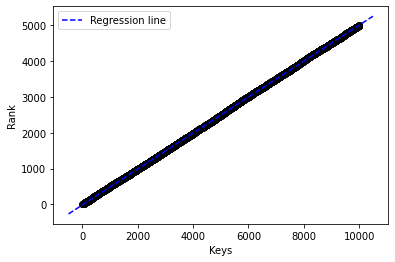

In [149]:
calculate_mean_squared_error(x, y)

## Linear regression with poisoned keys

In [150]:
poisoning_keys = obtain_poisoning_keys(p = 0.2, keyset=x, rankset=y)

<ipython-input-147-c8bd9ee43004>:61: RuntimeWarning: overflow encountered in ulong_scalars
  delta_S[i] = S[i+1] - S[i]


In [102]:
cProfile.run('obtain_poisoning_keys(p = 0.05, keyset=x, rankset=y)', sort = "time")

         1263929 function calls (1255873 primitive calls) in 0.545 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       76    0.255    0.003    0.378    0.005 <ipython-input-100-358a633792ea>:2(partition_non_occupied_keys_all_in_one)
   761945    0.061    0.000    0.061    0.000 {built-in method builtins.len}
     8588    0.032    0.000    0.032    0.000 {built-in method numpy.array}
   383876    0.031    0.000    0.031    0.000 {method 'append' of 'list' objects}
16492/8436    0.023    0.000    0.096    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     3800    0.023    0.000    0.069    0.000 <ipython-input-45-3d51dcaacfe3>:4(rankdata)
        1    0.022    0.022    0.545    0.545 <ipython-input-101-c8bd9ee43004>:4(obtain_poisoning_keys)
     3800    0.021    0.000    0.021    0.000 {method 'argsort' of 'numpy.ndarray' objects}
       76    0.009    0.000    0.130    0.002 <ipython-input-

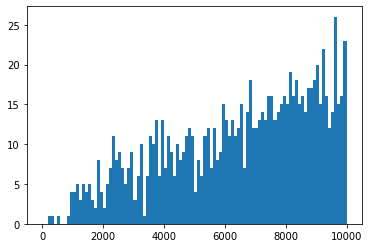

In [151]:
plot_distribution_of_poisoning_keys(poisoning_keys, x)

In [152]:
x_poisoned = np.append(x, list(poisoning_keys))
y_poisoned = rankdata(x_poisoned)
x_poisoned = x_poisoned.reshape(-1,1)

Mean Squared Error: 4239.088902108528


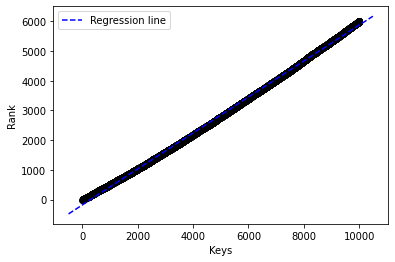

In [153]:
calculate_mean_squared_error(x_poisoned, y_poisoned)

In [18]:
#ratio_loss =  mse_poisoned / mse_legitimates

### Visualization

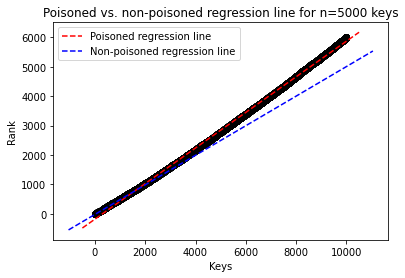

In [154]:
# Plot outputs
plot_poisoned_and_non_poisoned_regression_line(x, y, x_poisoned, y_poisoned)

### Write poisoned keyset to file

In [94]:
poisoned_keyset = pd.DataFrame(data=list(X_poisoned))
poisoned_keyset.to_csv("../data/poisoned_keyset_5000.csv", sep=',',index=False)

## Perform poisoning of SOSD benchmark files

In [171]:
def read_dataset(dataset_filename : str):
    keyset = np.fromfile("../data/" + dataset_filename, dtype=np.uint64)[1:]
    print("Length of keyset: ", len(keyset))
    rankset = rankdata(keyset)
    keyset = keyset.reshape(-1, 1)
    return (keyset, rankset)

In [172]:
x, y = read_dataset("wiki_ts_1M_uint64")

Length of keyset:  1526


Mean Squared Error: 19376.28075528213


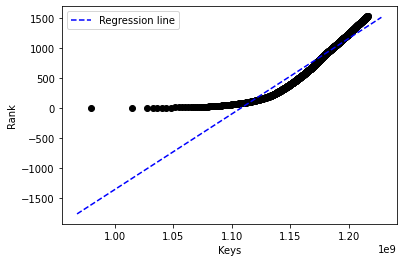

In [173]:
calculate_mean_squared_error(x, y)

In [174]:
x

array([[ 979672113],
       [1014648675],
       [1027557926],
       ...,
       [1216077107],
       [1216140173],
       [1216200177]], dtype=uint64)

In [175]:
y

array([   1,    2,    3, ..., 1524, 1525, 1526])

In [165]:
poisoning_keys = obtain_poisoning_keys(p = 0.20, keyset=x, rankset=y)

In [176]:
cProfile.run('obtain_poisoning_keys(p = 0.20, keyset=x, rankset=y)', sort = "time")

         46224723 function calls (46192393 primitive calls) in 15.782 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      305   10.191    0.033   14.883    0.049 <ipython-input-159-8a9a01165842>:2(partition_non_occupied_keys_all_in_one)
 30485194    2.460    0.000    2.460    0.000 {built-in method builtins.len}
 15265555    1.154    0.000    1.154    0.000 {method 'append' of 'list' objects}
    34465    1.094    0.000    1.094    0.000 {built-in method numpy.array}
        1    0.217    0.217   15.782   15.782 <ipython-input-147-c8bd9ee43004>:4(obtain_poisoning_keys)
    15250    0.105    0.000    0.330    0.000 <ipython-input-45-3d51dcaacfe3>:4(rankdata)
66185/33855    0.102    0.000    0.422    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    15250    0.092    0.000    0.092    0.000 {method 'argsort' of 'numpy.ndarray' objects}
    15250    0.057    0.000    0.057    0.000 {built-in m

In [166]:
poisoning_keys

{979673924,
 979674076,
 979674086,
 979674383,
 979674839,
 979675216,
 979676095,
 979676158,
 979677805,
 979678970,
 979679128,
 979679461,
 979681035,
 979681349,
 979681423,
 979681450,
 979682325,
 979682342,
 979682819,
 979683124,
 979683559,
 979685341,
 979685463,
 979686224,
 979686325,
 979687476,
 979687826,
 979687843,
 979688229,
 979688251,
 979688260,
 979688657,
 979689032,
 979689527,
 979689640,
 979690522,
 979690549,
 979690572,
 979690757,
 979690974,
 979691207,
 979691214,
 979691550,
 979691708,
 979691958,
 979692299,
 979692761,
 979693172,
 979693508,
 979693619,
 979694129,
 979694136,
 979694307,
 979694493,
 979695394,
 979695793,
 979695880,
 979696215,
 979696266,
 979696357,
 979696654,
 979696786,
 979696833,
 979696837,
 979696847,
 979696948,
 979697287,
 979697525,
 979698160,
 979698730,
 979698936,
 979700115,
 979700744,
 979700906,
 979701579,
 979702144,
 979702207,
 979702301,
 979702445,
 979702710,
 979703141,
 979703398,
 979703599,
 979

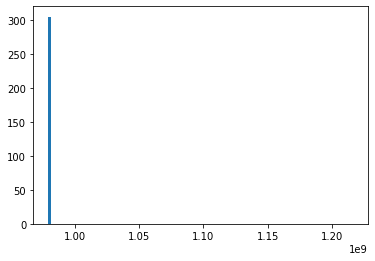

In [167]:
plot_distribution_of_poisoning_keys(poisoning_keys, x)

In [168]:
x_poisoned = np.append(x, list(poisoning_keys))
y_poisoned = rankdata(x_poisoned)
x_poisoned = x_poisoned.reshape(-1,1)

Mean Squared Error: 63812.51238979013


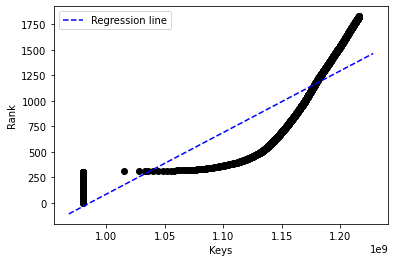

In [169]:
calculate_mean_squared_error(x_poisoned, y_poisoned)

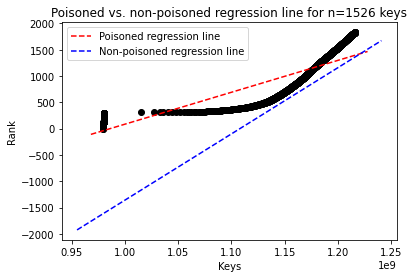

In [170]:
# Plot outputs
plot_poisoned_and_non_poisoned_regression_line(x, y, x_poisoned, y_poisoned)

## Linear regression experiments with different key sizes / different poisoning percentages

In [15]:
import random

def generate_uniform_data(size):
    
    data = random.sample(range(2, size * 2), size)
    data.sort()
    return data

-------------------------
Dataset size:  500
Mean Squared Error: 10.816464904609312
Mean Squared Error: 11.11713079239834
Mean Squared Error: 12.038229273838143
Mean Squared Error: 13.815707106720806
Mean Squared Error: 17.88193188797914
Mean Squared Error: 24.44914795010329
Mean Squared Error: 29.810067013172063
Mean Squared Error: 40.357670960423974
Mean Squared Error: 53.644429094707164
Mean Squared Error: 66.05976278804661
Mean Squared Error: 84.0755512105039
Mean Squared Error: 105.08008239241076
Mean Squared Error: 128.41479806191754
Mean Squared Error: 148.75057197227716
Mean Squared Error: 169.84725277689816


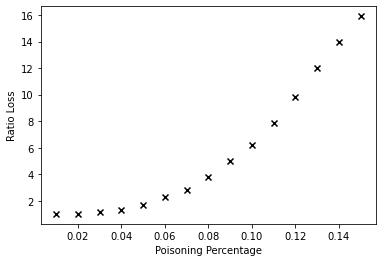

-------------------------
Dataset size:  1000
Mean Squared Error: 20.773564268523586
Mean Squared Error: 25.78819890323834
Mean Squared Error: 38.20042041745141
Mean Squared Error: 56.34731516231744
Mean Squared Error: 76.13307741398904
Mean Squared Error: 104.00910688645017
Mean Squared Error: 137.53844998726439
Mean Squared Error: 188.29765677644156
Mean Squared Error: 243.60929879108775
Mean Squared Error: 307.26563547759065
Mean Squared Error: 379.5819577658792
Mean Squared Error: 459.9276318940463
Mean Squared Error: 527.3773904911287
Mean Squared Error: 609.9754483106909
Mean Squared Error: 708.88213444713


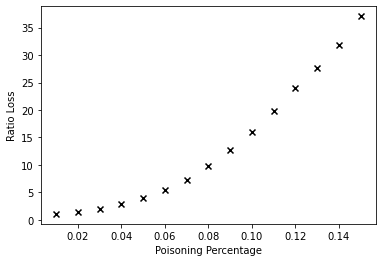

In [16]:
dataset_sizes = [500, 1000]

for dataset_size in dataset_sizes:
    
    print("-------------------------")
    print("Dataset size: ", dataset_size)
    X = generate_uniform_data(dataset_size)
    X = np.array(X).reshape(-1, 1)
    
    y = np.linspace(1, dataset_size, num=dataset_size)

    poisoning_percentages = np.linspace(0.01, 0.15, num= 15)

    ratio_losses = []
    
    regressor_legitimate = LinearRegression()
    regressor_legitimate.fit(X, y) 

    y_pred = regressor_legitimate.predict(X)
    mse_legitimate = metrics.mean_squared_error(y, y_pred)

    for percentage in poisoning_percentages:
        poisoning_keys = obtain_poisoning_keys(p = percentage, keyset = X, rankset = y)

        #plot_poisoning_keys(poisoning_keys)

        X_poisoned = np.append(X, list(poisoning_keys))
        y_poisoned = rankdata(X_poisoned)

        X_poisoned = X_poisoned.reshape(-1,1)
        regressor_poisoned = LinearRegression()
        regressor_poisoned.fit(X_poisoned, y_poisoned)  

        y_poisoned_pred = regressor_poisoned.predict(X_poisoned)

        print('Mean Squared Error:', metrics.mean_squared_error(y_poisoned, y_poisoned_pred))  
        mse_poisoned = metrics.mean_squared_error(y_poisoned, y_poisoned_pred)
        ratio_loss =  mse_poisoned / mse_legitimate

        ratio_losses.append(ratio_loss)

    plt.scatter(poisoning_percentages, ratio_losses,  color='black', marker="x")
    plt.xlabel('Poisoning Percentage')
    plt.ylabel('Ratio Loss')
    plt.show()